In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
custom_cmp = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',\
                '#7f7f7f', '#bcbd22', '#17becf', '#FB9E9D', '#FDBF6F', '#B2DF8A', '#CAAAC7', '#10C19B'])
matplotlib.rcParams.update({'font.size': 8.5})
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [10]:
class GMM:
    def __init__(self, n_clusters, max_iter=100, init_method="random"):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.pi = np.ones(n_clusters) / n_clusters
        self.means = None
        self.covs = None
        self.labels = None
        self.init_method = init_method
        
    def initialize(self, data):
        if(self.init_method == "kmeans"):
            m = data.shape[1]
            kmeans = KMeans(n_clusters=self.n_clusters).fit(data)
            self.means = kmeans.cluster_centers_
            self.covs = np.zeros((self.n_clusters, m, m))
            labels = kmeans.predict(data)
            for i in range(self.n_clusters):
                self.covs[i] = np.cov(data[labels == i].T)
        elif(self.init_method == "random"):
            rand_points = np.random.randint(data.shape[0], size=self.n_clusters)
            self.means = data[rand_points, :]
            splitted_data = np.array_split(data, self.n_clusters) 
            self.covs = [np.cov(x.T) for x in splitted_data]
        else:
            raise Exception("Unknown initialization method")

    def multivariate_normal(self, data, mean, cov):
        return multivariate_normal(mean=mean, cov=cov, allow_singular=True).pdf(data)
    
    def e_step(self, data):
        r = np.zeros((len(data), self.n_clusters))
        for i in range(self.n_clusters):
            r[:, i] = self.pi[i] * self.multivariate_normal(data, self.means[i], self.covs[i])
            
        r = r / r.sum(axis=1)[:, np.newaxis]

        return r
        
    def m_step(self, data, r):        
        new_pi = r.mean(axis=0)
        
        new_means = np.zeros_like(self.means)
        for i in range(self.n_clusters):
            new_means[i] = np.multiply(r[:, i][:, np.newaxis], data).sum(axis=0) / r[:, i].sum()
        
        new_covs = np.zeros_like(self.covs)
        for k in range(self.n_clusters):
            diff = data - self.means[k]
            new_covs[k] = np.dot(r[:, k] * diff.T, diff) / r[:, k].sum()
            # new_covs[i].flat[::data.shape[1] + 1] += 1e-6
            
        return new_pi, new_means, np.nan_to_num(new_covs)
        
        
    def fit(self, data):
        # Initializing means and cov 
        self.initialize(data)

        # EM steps
        for iter_count in range(self.max_iter):
            r = self.e_step(data)
            pi, means, covs = self.m_step(data, r)
            
            if(np.allclose(self.pi, pi) and np.allclose(self.means, means) and np.allclose(self.covs, covs)):
            #    print(f'Algorthm has converged at {iter_count}th iteration')
               break
                
            self.pi = pi
            self.means = means
            self.covs = covs
    
    def predict(self, data):
        posteriors = np.zeros((len(data), self.n_clusters))
        for i in range(self.n_clusters):
            posteriors[:, i] = self.pi[i] * self.multivariate_normal(data, self.means[i], self.covs[i])
        labels = np.argmax(posteriors, axis=1)
        self.labels = labels
        return labels
        
    def plot_predictions(self, data, y_pred, ax = None, title = None):
        title = f"GMM - Number of clusters = {self.n_clusters}" if (title == None) else title
        if(ax == None):
            fig, ax = plt.subplots() 
        for idx, lbl in enumerate(np.unique(y_pred)):
            rgba = list(custom_cmp(idx))
            ax.scatter(data[:, 0][y_pred == lbl], data[:, 1][y_pred == lbl], color=rgba, s=2)
        # ax.scatter(data[:, 0], data[:, 1], s=2, c=y_pred, cmap=custom_cmp)    
        ax.scatter(np.array(self.means)[:, 0], np.array(self.means)[:, 1], color='black', s=100, marker="*")
        ax.set_title(title, fontdict={"fontsize": 9.5})
        ax.set_xlabel("1st feature")
        ax.set_ylabel("2nd feature")
        if(ax == None):
            plt.tight_layout()

    def plot_silhouette(self, data, y_pred, ax = None, title = None):
        cluster_labels = np.unique(y_pred)
        num_clusters = cluster_labels.shape[0]
        silhouette_vals = metrics.silhouette_samples(data, y_pred)

        y_lower, y_upper = 10, 0
        y_ticks = []

        for idx, cls in enumerate(cluster_labels):
            cls_silhouette_vals = silhouette_vals[y_pred==cls]
            cls_silhouette_vals.sort()
            y_upper = len(cls_silhouette_vals) + y_lower
            rgba = list(custom_cmp(idx))
            rgba[-1] = 0.7
            ax.fill_betweenx(
                np.arange(y_lower, y_upper), 
                0,
                cls_silhouette_vals,
                edgecolor='none',
                facecolor=rgba)
            y_ticks.append((y_lower + y_upper) / 2.0)
            y_lower = y_upper + 10

        silhouette_avg = np.mean(silhouette_vals)
        if(ax == None):
            fig, ax = plt.subplots()
        ax.axvline(silhouette_avg, color='black', linestyle='--')
        ax.set_xlabel('Silhouette coefficient')
        ax.set_ylabel('Cluster')
        ax.set_title(title, fontdict={"fontsize": 9.5})
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(data) + (self.n_clusters + 1) * 10])
        ax.set_yticks([])
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_yticks(y_ticks, cluster_labels + 1)
        if(ax == None):
            plt.tight_layout()

In [33]:
def report_scores(data, k_s):
    silhouette_scores=[]
    calinski_scores=[]
    davies_scores=[]
    silhouette_errs=[]
    for k in k_s:
        tmp_cali_scores=[]
        tmp_sil_scores=[]
        tmp_davi_scores=[]
        for _ in range(50):
            gmm=GMM(n_clusters=k)
            gmm.fit(data) 
            labels=gmm.predict(data)
            sil_score = metrics.silhouette_score(data, labels, metric='euclidean')
            cali_score = metrics.calinski_harabasz_score(data, labels)
            davi_score = metrics.davies_bouldin_score(data, labels)
            tmp_sil_scores.append(sil_score)
            tmp_cali_scores.append(cali_score)
            tmp_davi_scores.append(davi_score)
        dx = np.argsort(tmp_sil_scores)[:10]
        sil_score = np.mean(np.array(tmp_sil_scores)[dx])
        err=np.std(tmp_sil_scores)
        silhouette_errs.append(err)
        silhouette_scores.append(sil_score)

        dx = np.argsort(tmp_cali_scores)[:10]
        cali_score = np.mean(np.array(tmp_cali_scores)[dx])
        calinski_scores.append(cali_score)

        dx = np.argsort(tmp_davi_scores)[:10]
        davi_score = np.mean(np.array(tmp_davi_scores)[dx])
        davies_scores.append(davi_score)
    
    fig, ax = plt.subplots()
    plt.plot(k_s, silhouette_scores, color="#0272A2", marker="D", markersize=5, linestyle='--')
    ax.set_title("Silhouette Analysis", fontsize=11, fontweight="bold")
    ax.set_xticks(k_s)
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Silhouette Score")
    plt.tight_layout()
    
    fig, ax = plt.subplots()
    plt.plot(k_s, calinski_scores, color="#0272A2", marker="D", markersize=5, linestyle='--')
    ax.set_title("Calinski-Harabasz Index Analysis", fontsize=11, fontweight="bold")
    ax.set_xticks(k_s)
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Calinski Score")
    plt.tight_layout()
    
    fig, ax = plt.subplots()
    plt.plot(k_s, davies_scores, color="#0272A2", marker="D", markersize=5, linestyle='--')
    ax.set_title("Davies-Bouldin Index Analysis", fontsize=11, fontweight="bold")
    ax.set_xticks(k_s)
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Davies-Bouldin Score")
    plt.tight_layout()

def plot_data(X, y, ax = None, title = None):
    if(ax == None):
        fig, ax = plt.subplots() 
    ax.scatter(X[:, 0], X[:, 1], s=2, c=y, cmap=custom_cmp)
    ax.set_title(title, fontdict={"fontsize": 9.5})
    ax.set_xlabel("1st feature")
    ax.set_ylabel("2nd feature")
    if(ax == None):
        plt.tight_layout()

In [4]:
k_s = [2, 3, 5, 7, 8, 10]

<h2>TSNV dataset</h2>

In [25]:
data = pd.read_csv('tsnv.csv').to_numpy()
X = data
y = np.ones(data.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

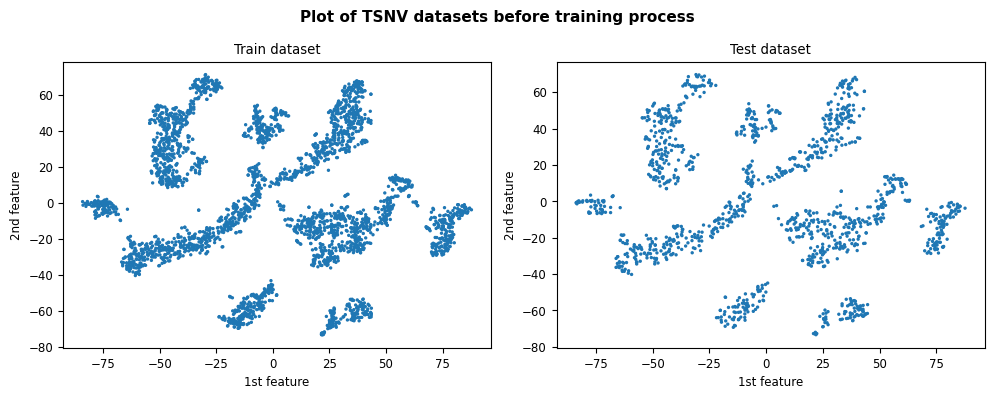

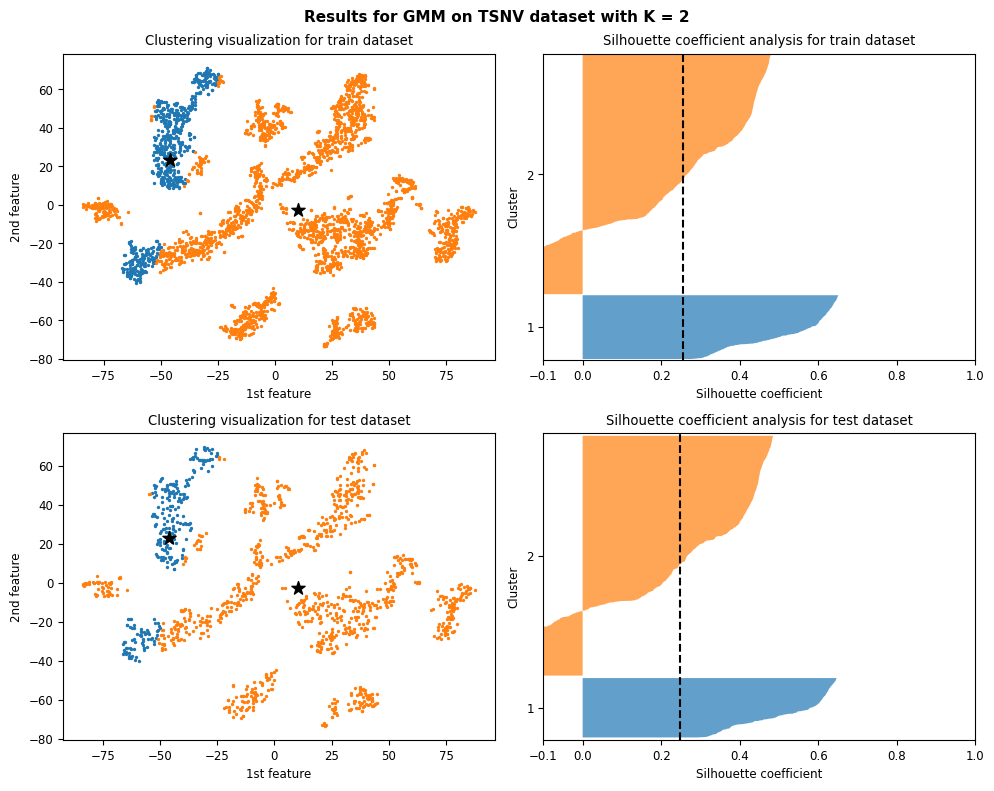

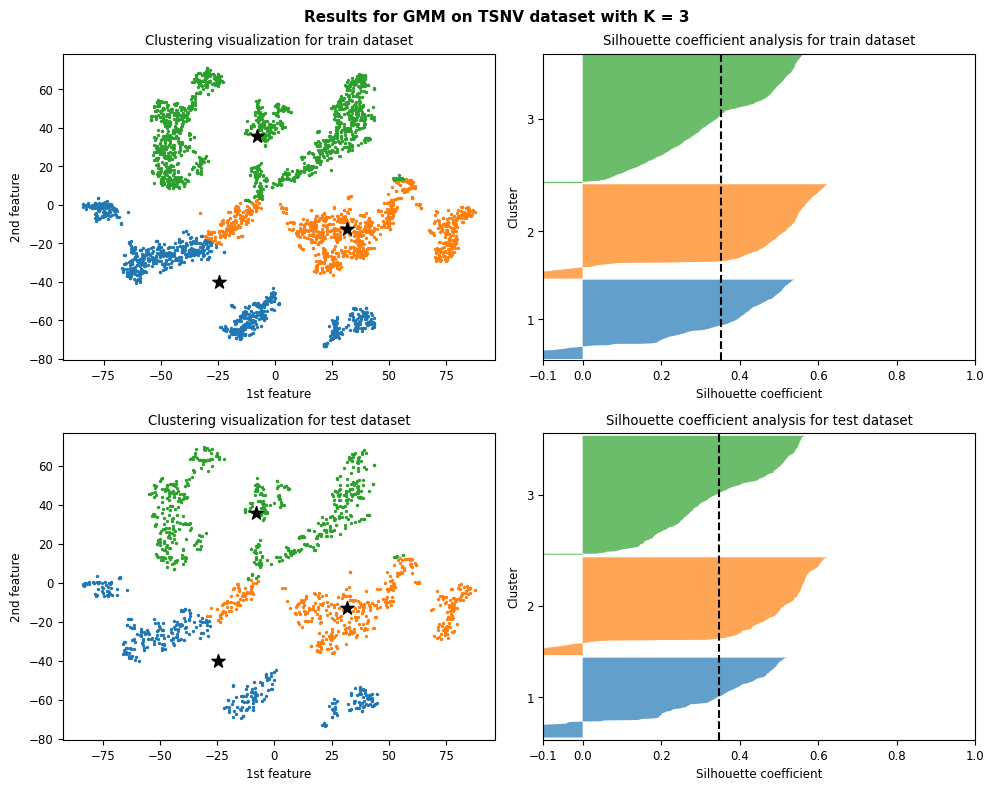

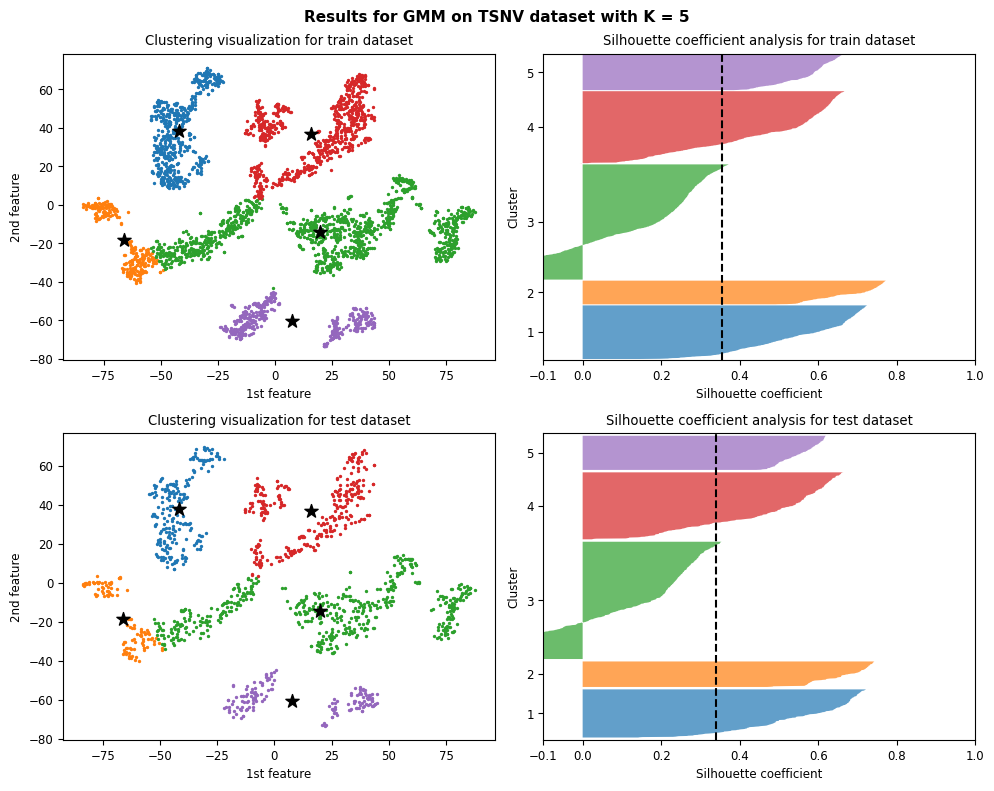

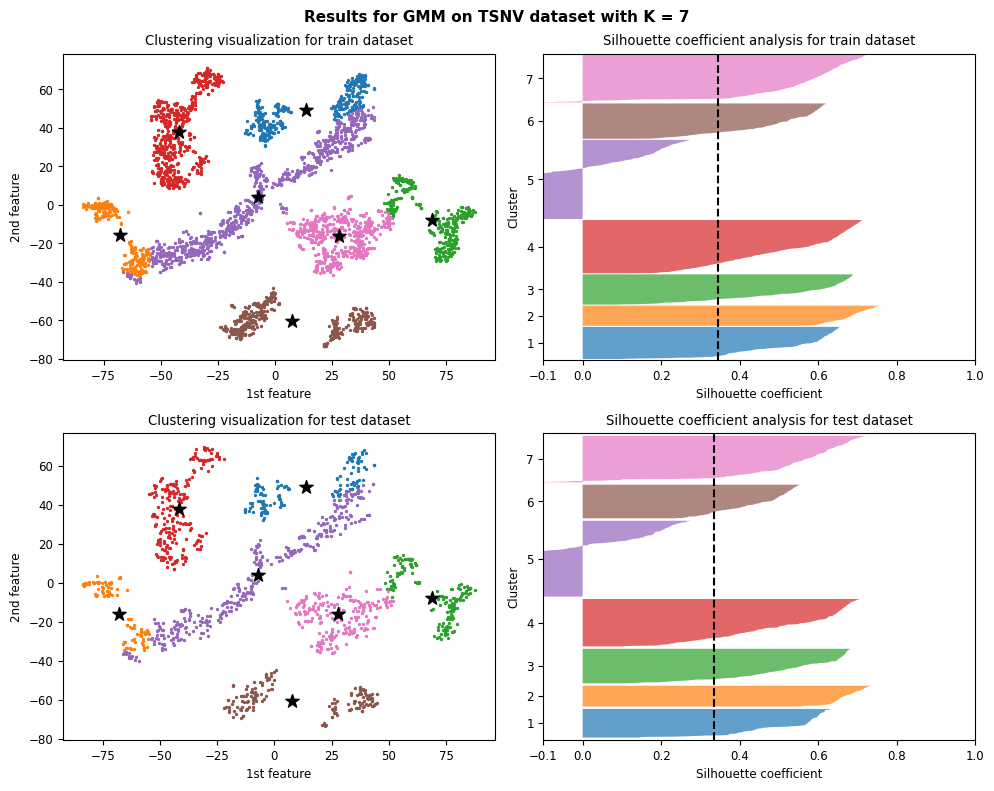

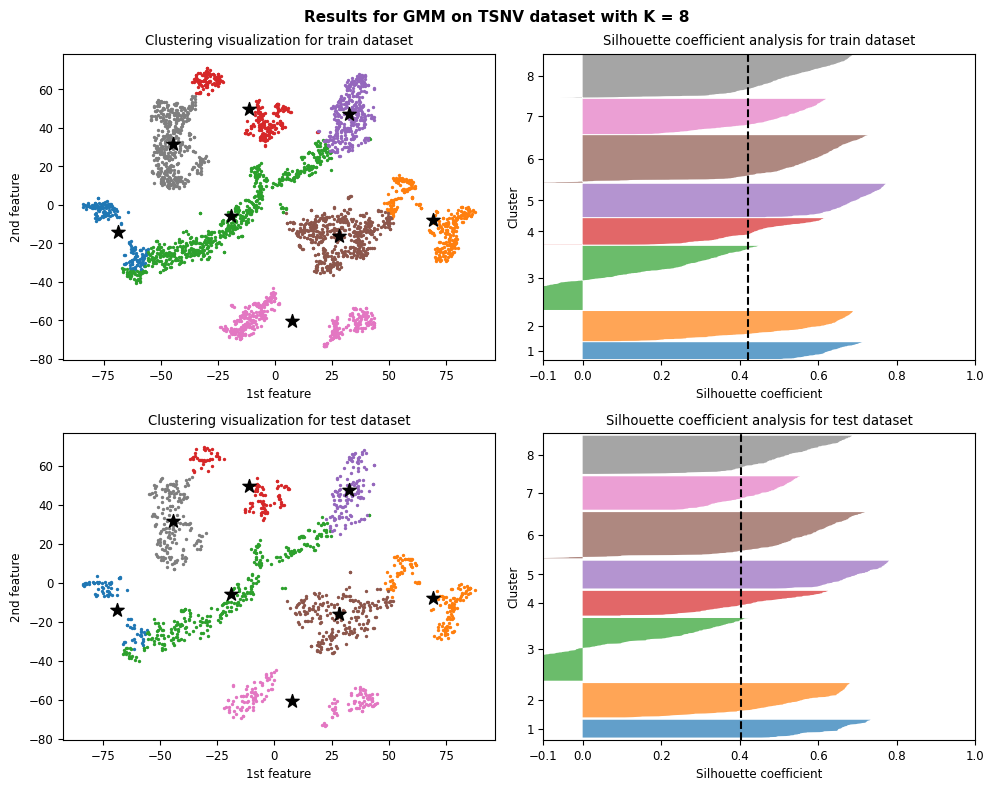

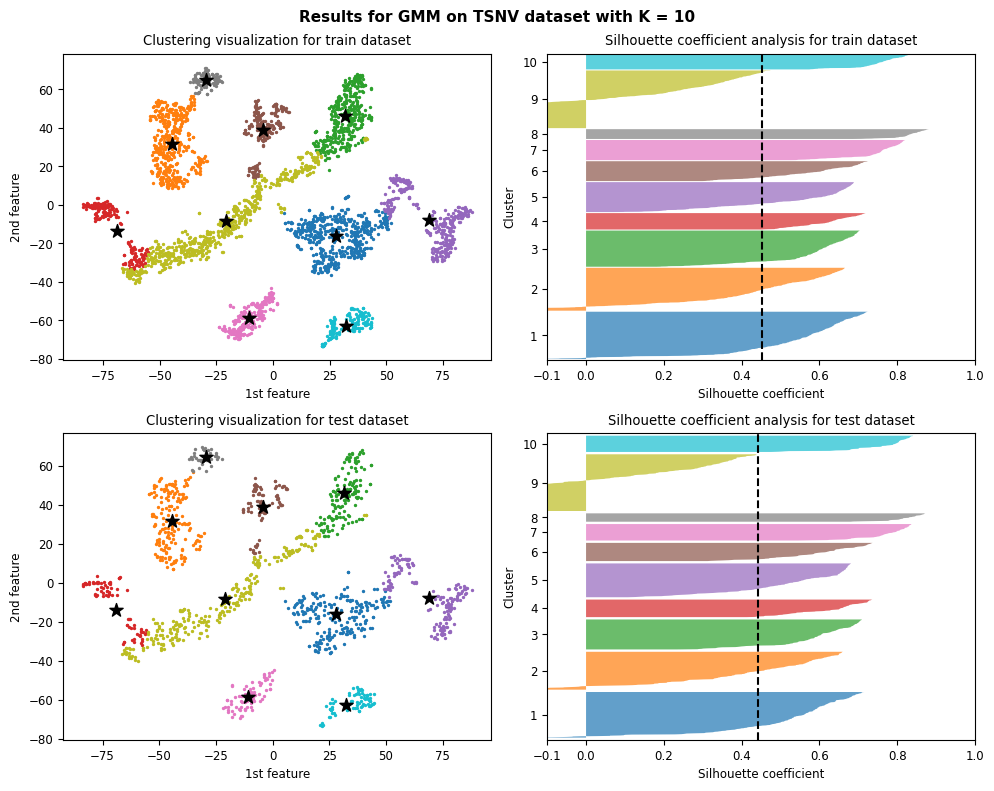

In [14]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
plot_data(X_train, y_train, ax=axs[0], title="Train dataset")
plot_data(X_test, y_test, ax=axs[1], title="Test dataset")
fig.suptitle(f"Plot of TSNV datasets before training process", fontsize=11, fontweight="bold")
plt.tight_layout()

for k in k_s:
    model = GMM(n_clusters=k)
    model.fit(X_train)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    y_pred = model.predict(X_train)
    model.plot_predictions(X_train, y_pred, ax=axs[0, 0], title=f"Clustering visualization for train dataset")
    model.plot_silhouette(X_train, y_pred, ax=axs[0, 1], title="Silhouette coefficient analysis for train dataset")
    y_pred = model.predict(X_test)
    model.plot_predictions(X_test, y_pred, ax=axs[1, 0], title=f"Clustering visualization for test dataset")
    model.plot_silhouette(X_test, y_pred, ax=axs[1, 1], title="Silhouette coefficient analysis for test dataset")
    fig.suptitle(f"Results for GMM on TSNV dataset with K = {k}", fontsize=11, fontweight="bold")
    plt.tight_layout()

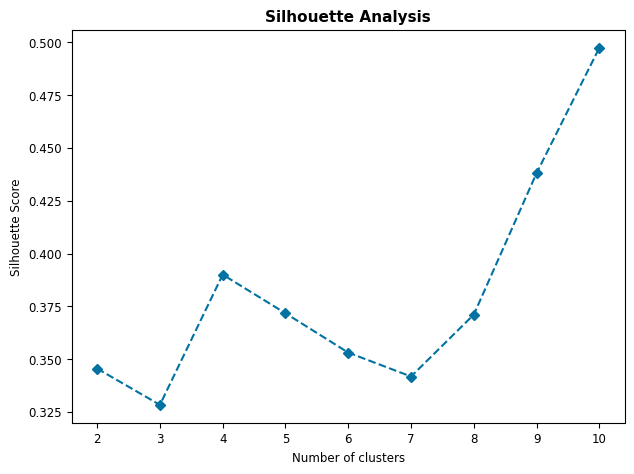

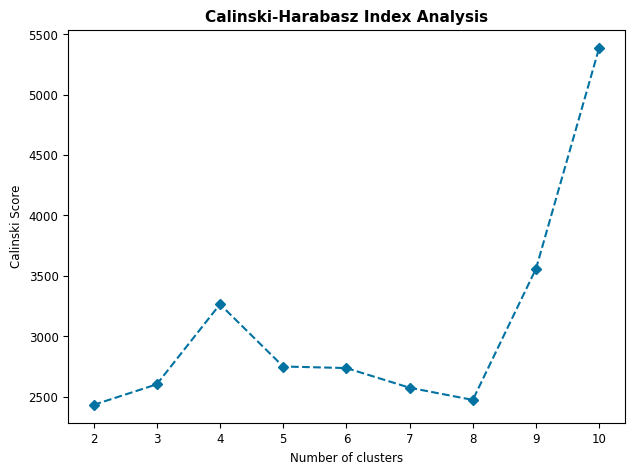

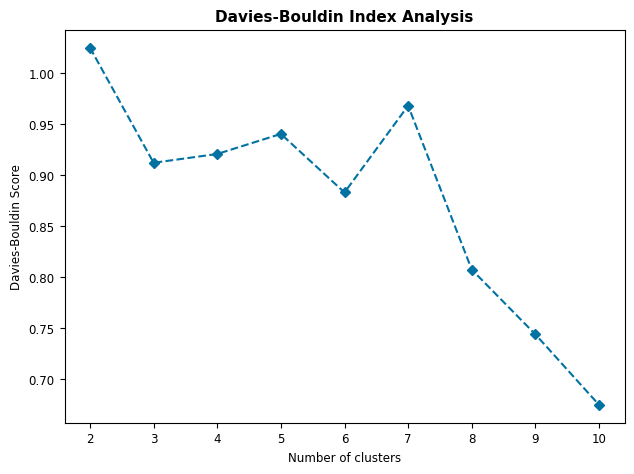

In [26]:
report_scores(data, np.arange(2, 11))

<h2>Blobs dataset</h2>

In [36]:
data = pd.read_csv('blobs.csv').to_numpy()
X = data[:, :-1]
y = data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

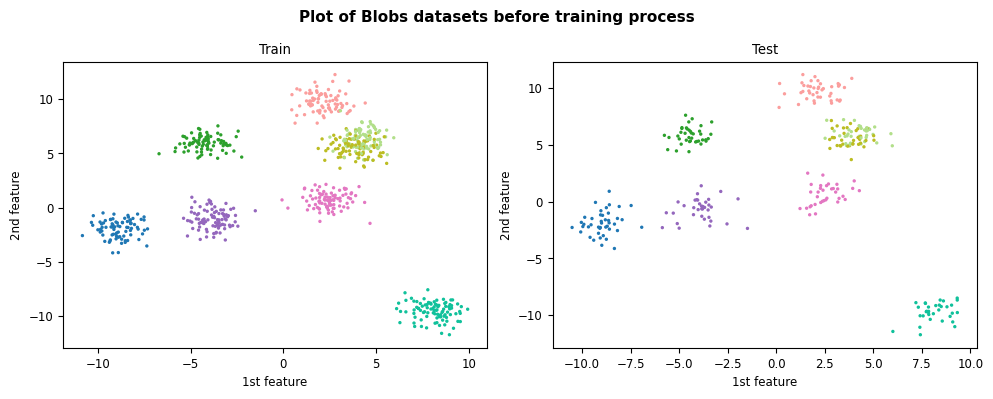

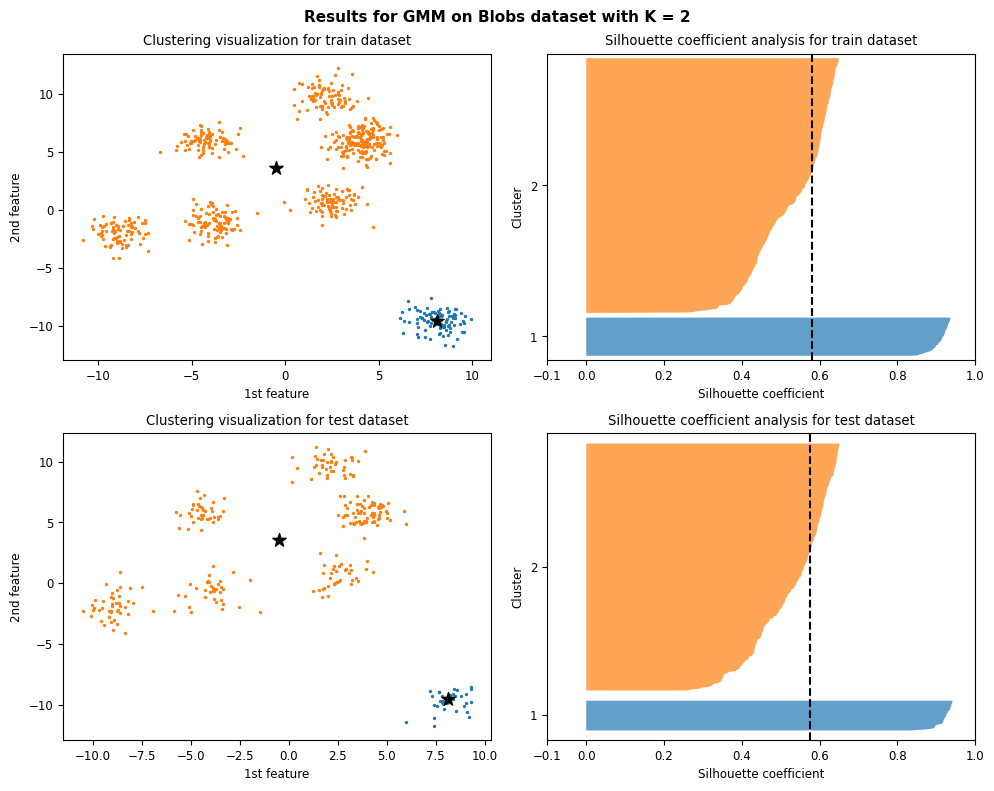

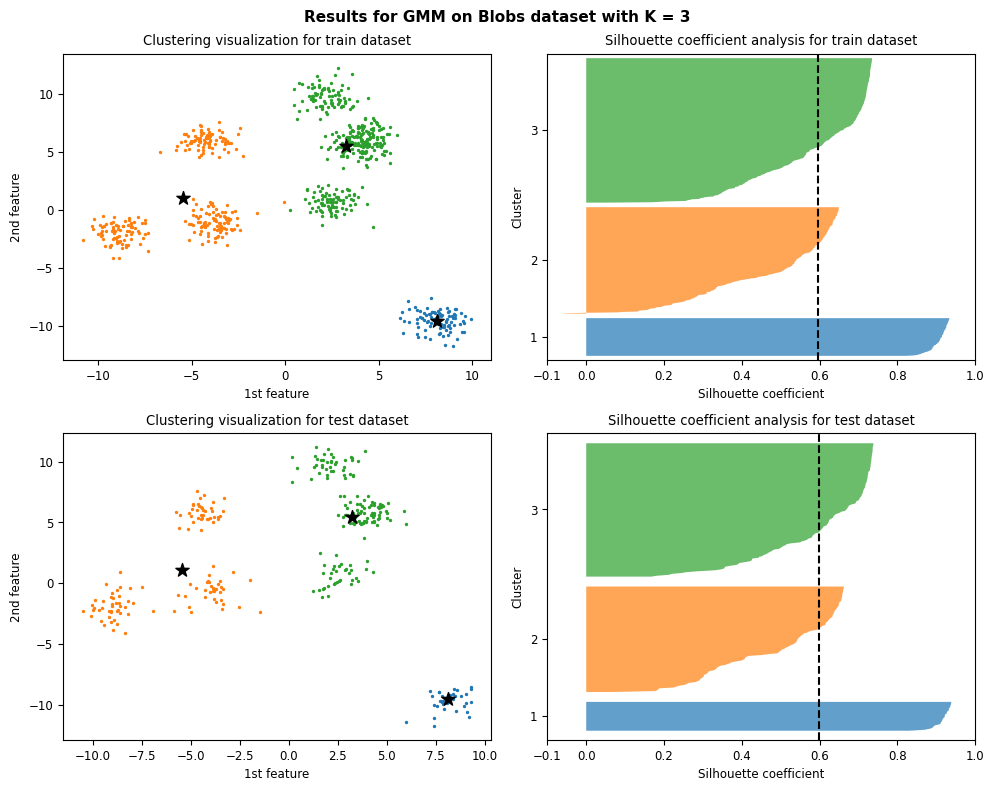

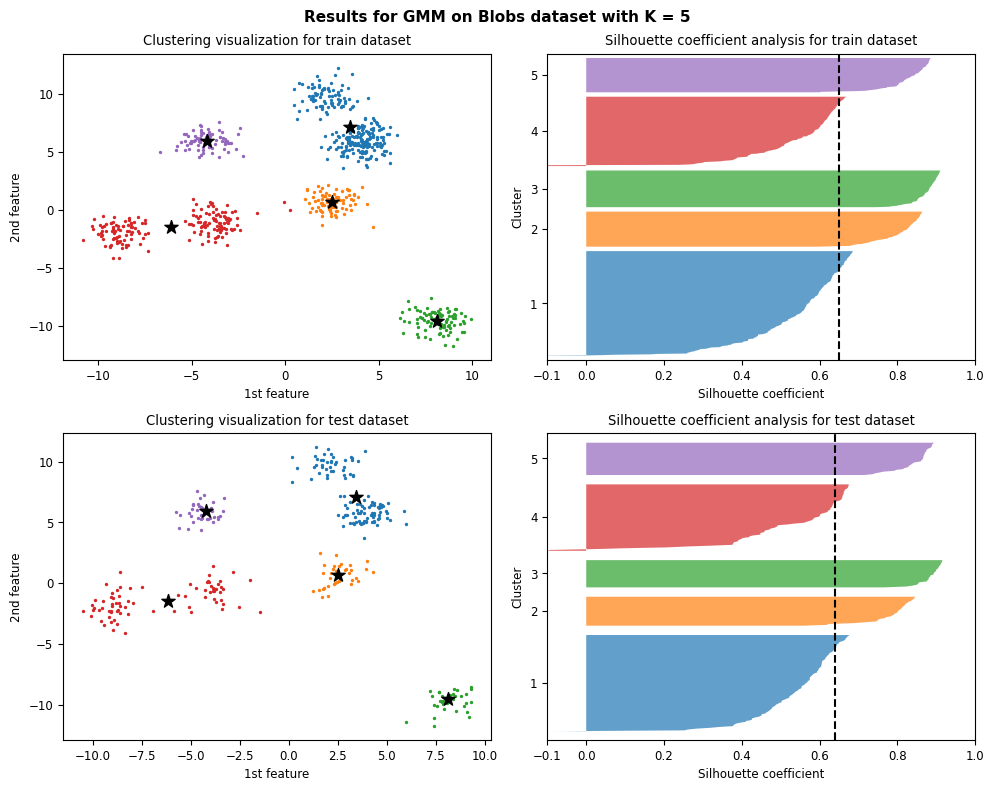

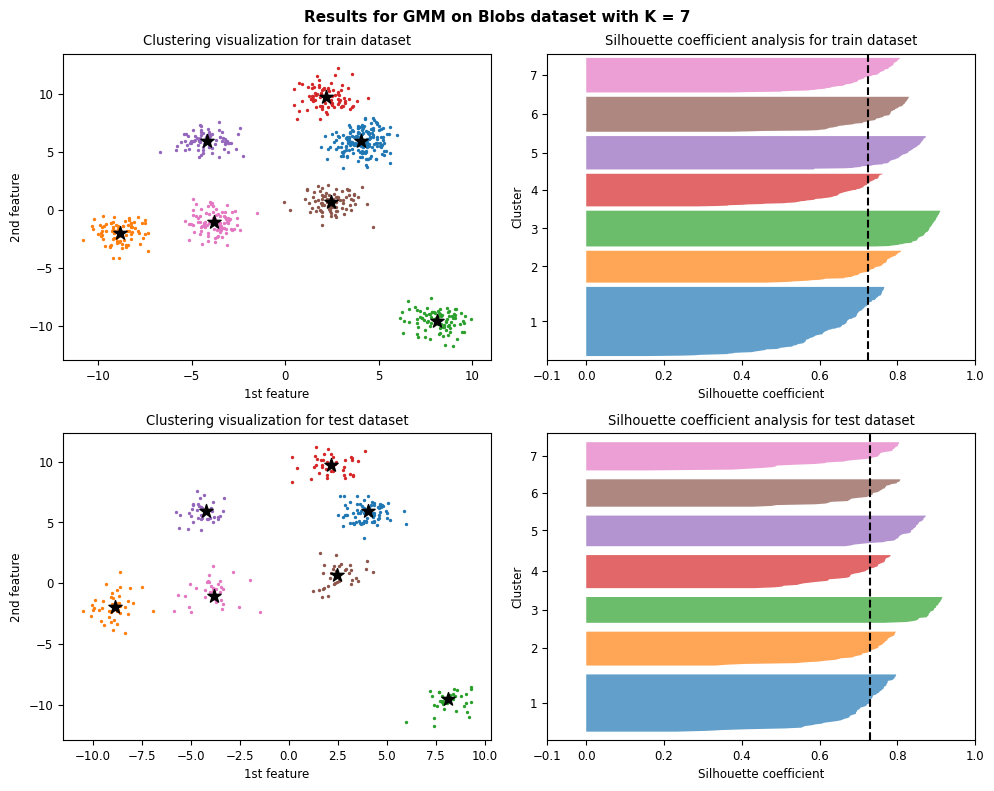

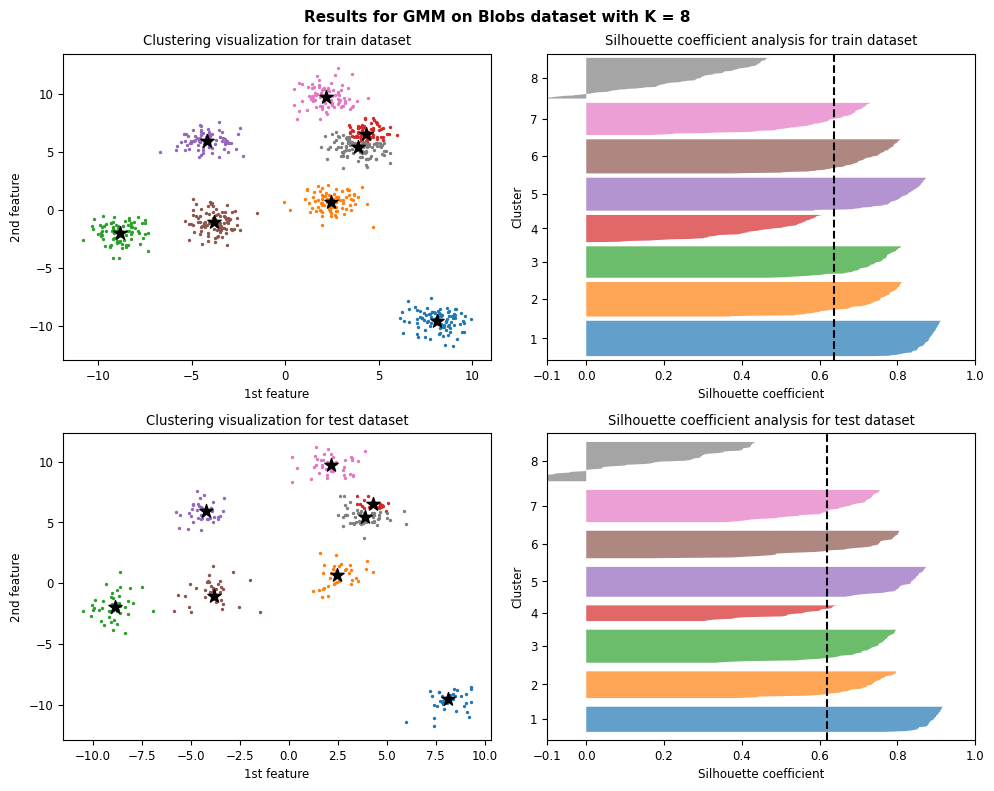

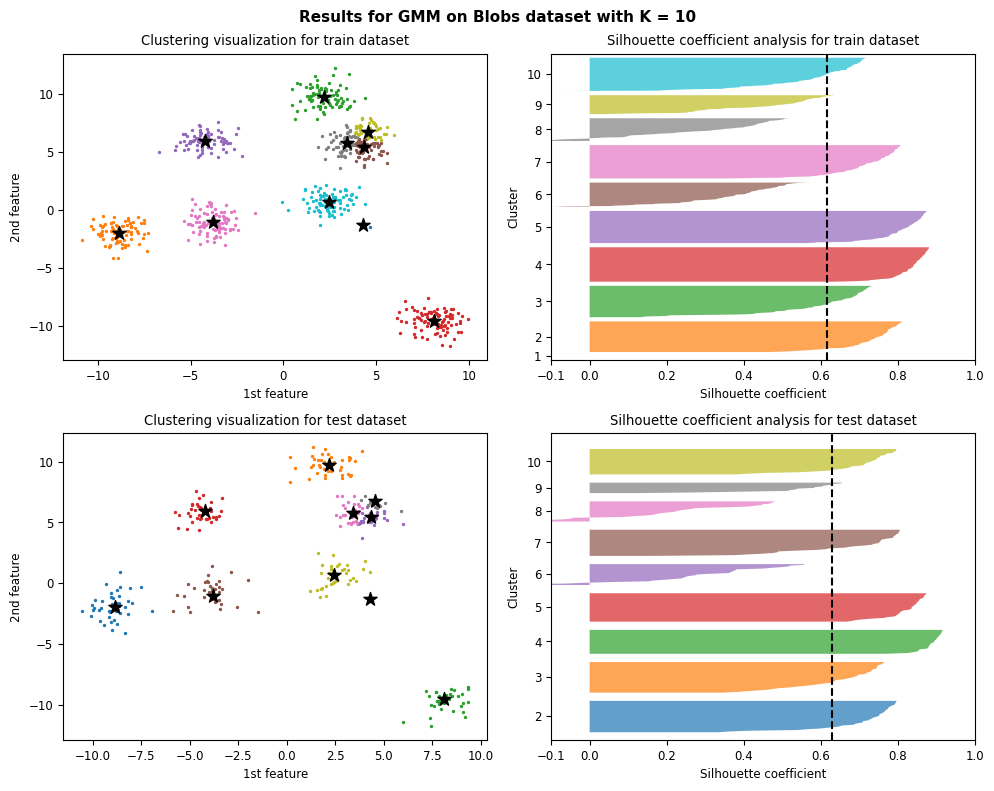

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
plot_data(X_train, y_train, ax=axs[0], title="Train")
plot_data(X_test, y_test, ax=axs[1], title="Test")
fig.suptitle(f"Plot of Blobs datasets before training process", fontsize=11, fontweight="bold")
plt.tight_layout()

for k in k_s:
    model = GMM(n_clusters=k)
    model.fit(X_train)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    y_pred = model.predict(X_train)
    model.plot_predictions(X_train, y_pred, ax=axs[0, 0], title=f"Clustering visualization for train dataset")
    model.plot_silhouette(X_train, y_pred, ax=axs[0, 1], title="Silhouette coefficient analysis for train dataset")
    y_pred = model.predict(X_test)
    model.plot_predictions(X_test, y_pred, ax=axs[1, 0], title=f"Clustering visualization for test dataset")
    model.plot_silhouette(X_test, y_pred, ax=axs[1, 1], title="Silhouette coefficient analysis for test dataset")
    fig.suptitle(f"Results for GMM on Blobs dataset with K = {k}", fontsize=11, fontweight="bold")
    plt.tight_layout()

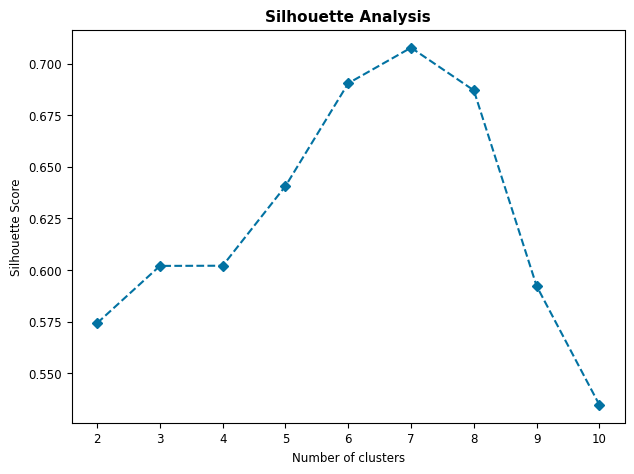

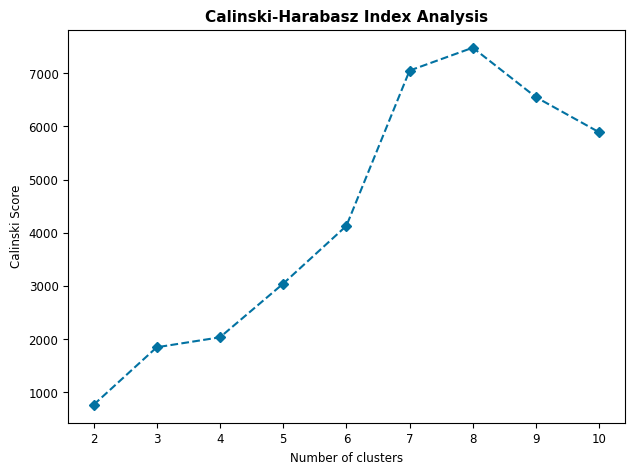

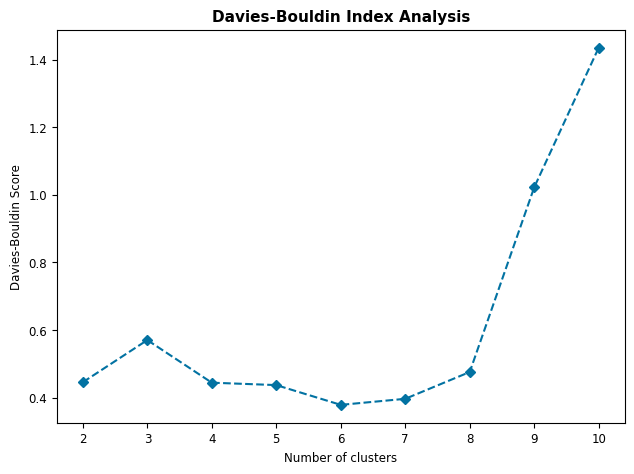

In [35]:
report_scores(data, np.arange(2, 11))

<h2>Elliptical dataset</h2>

In [37]:
data = pd.read_csv('elliptical.csv').to_numpy()
X = data[:, :-1]
y = data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

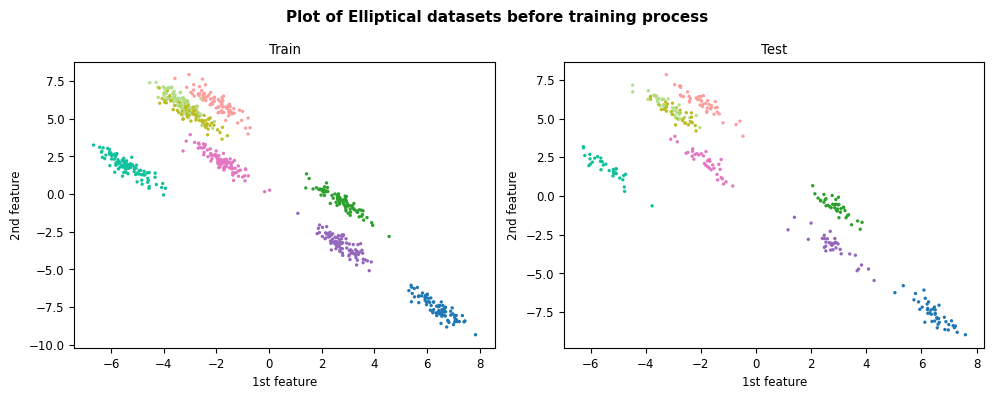

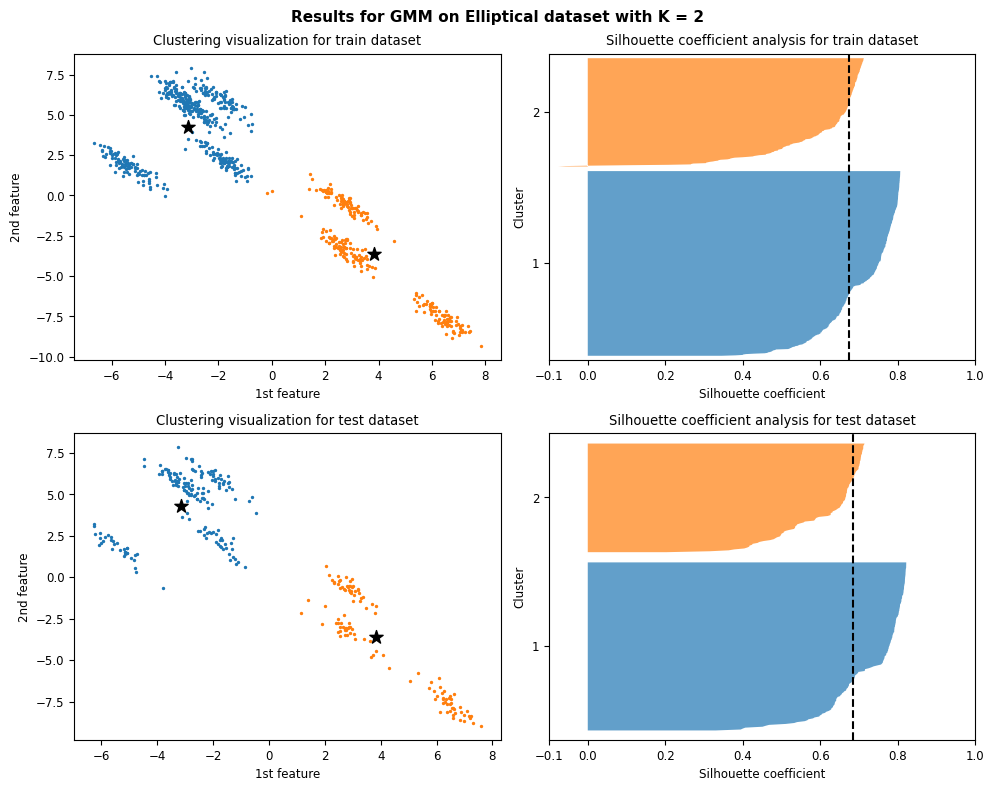

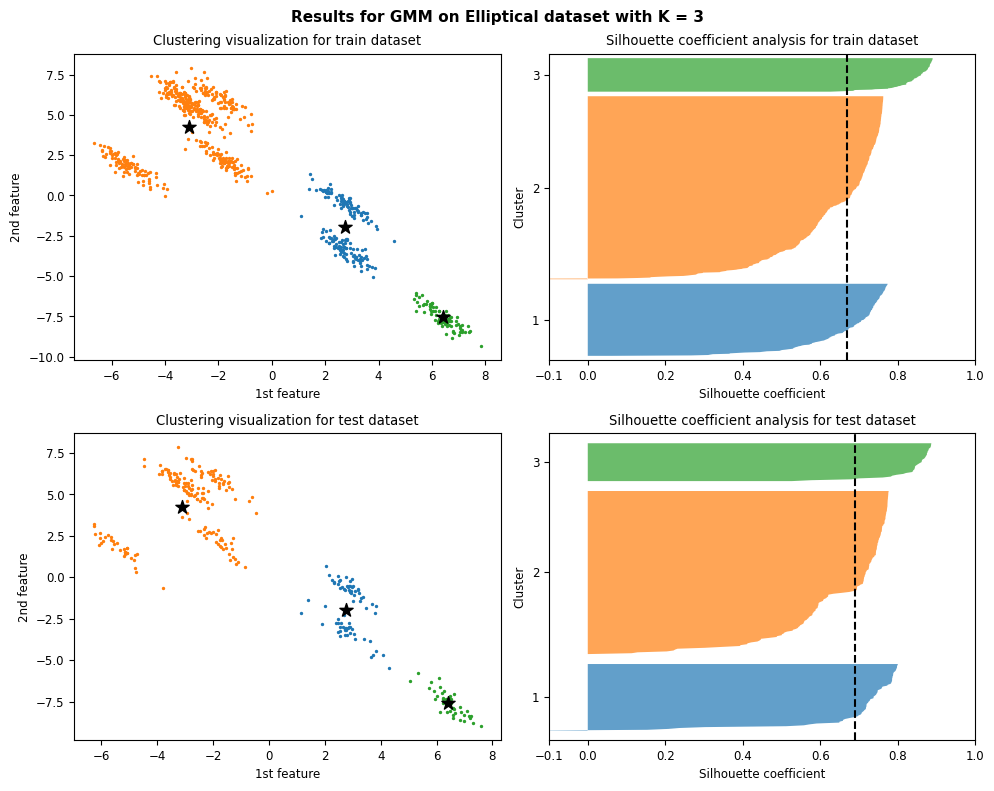

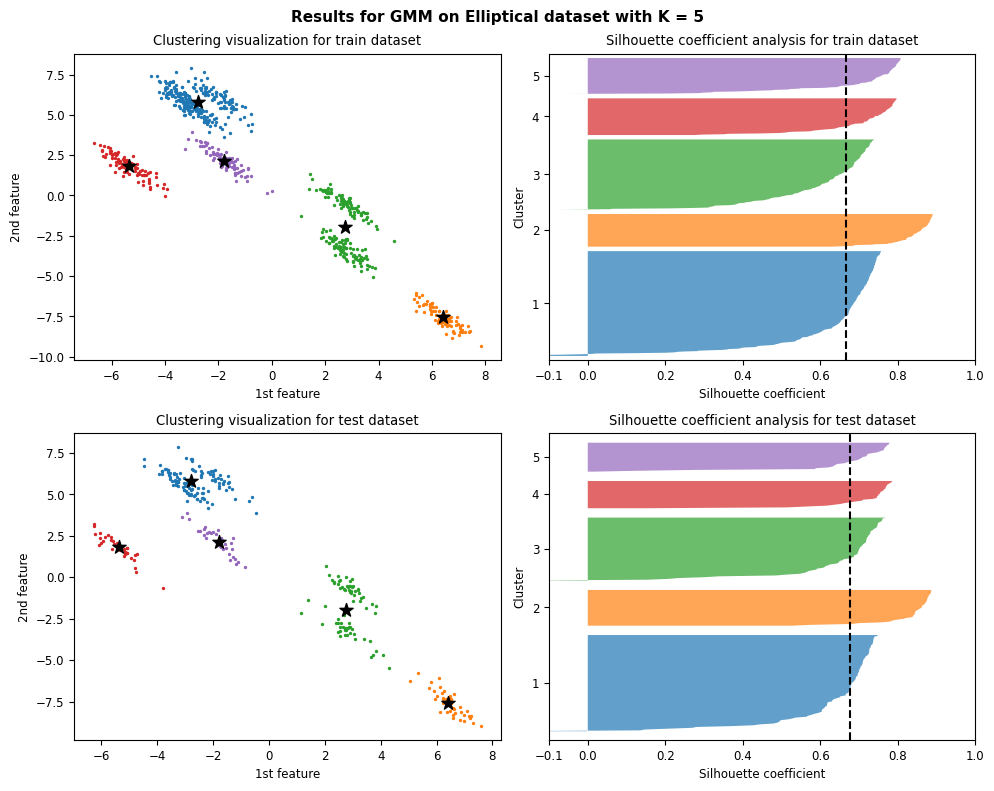

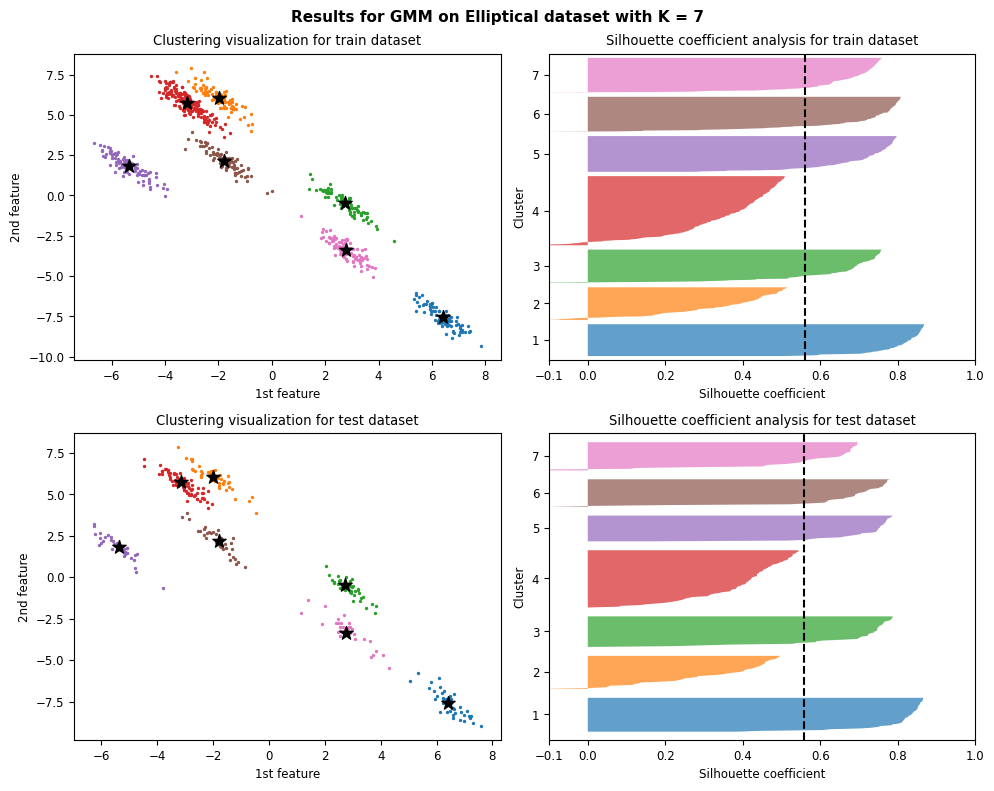

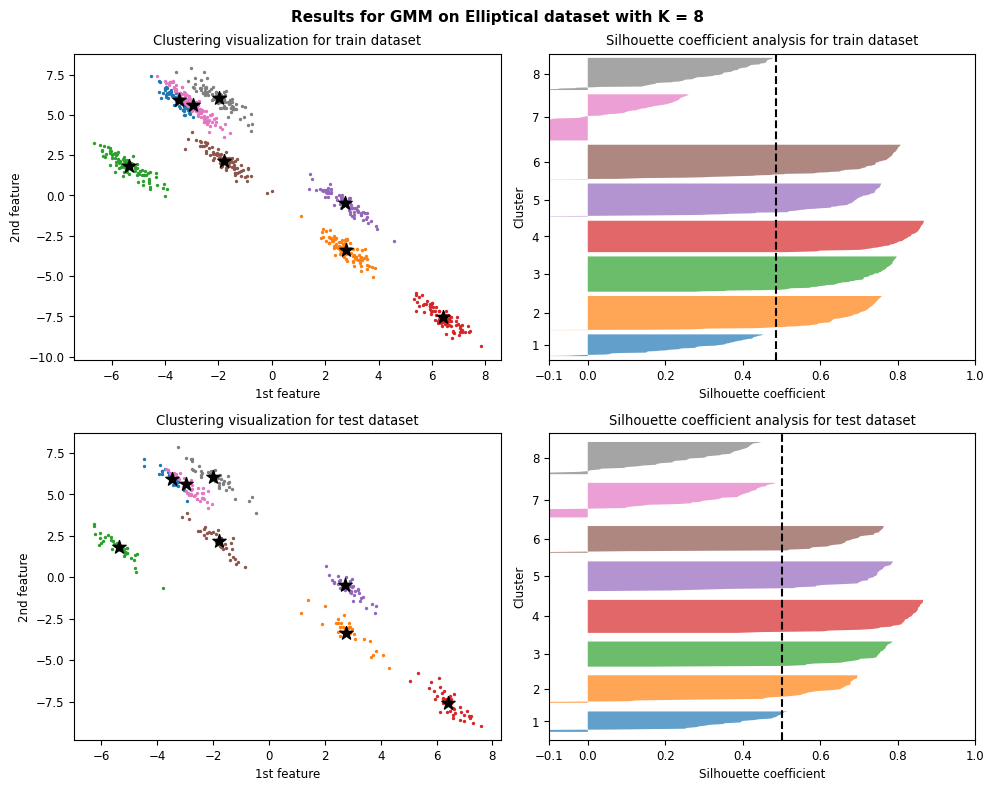

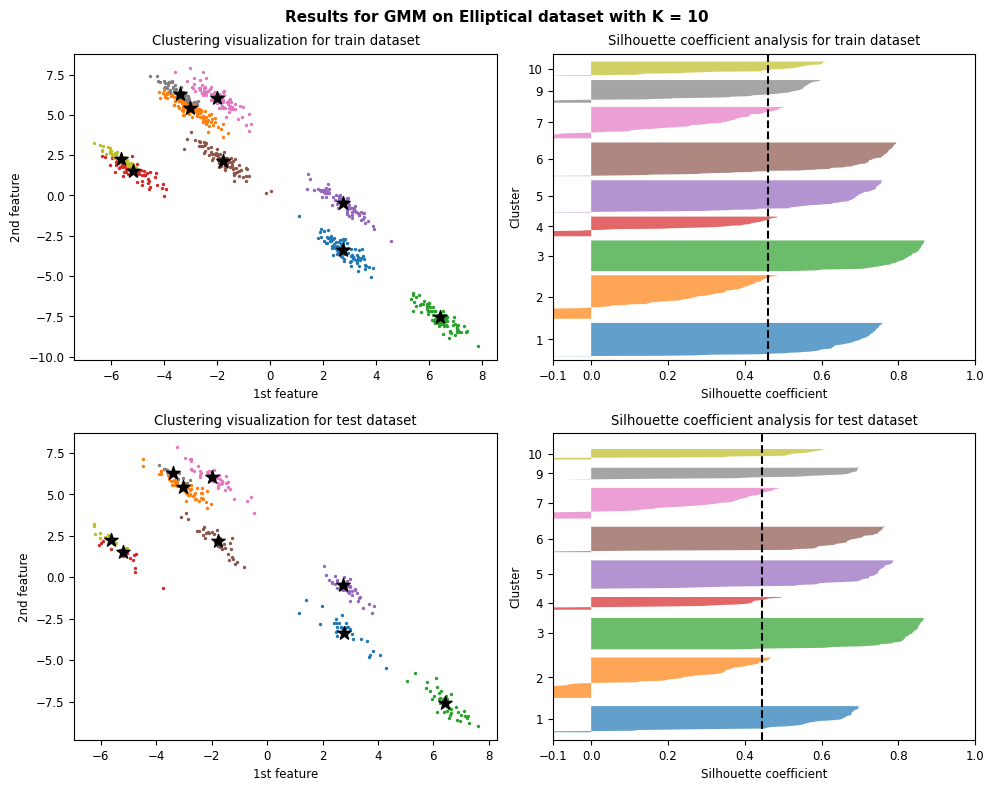

In [42]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
plot_data(X_train, y_train, ax=axs[0], title="Train")
plot_data(X_test, y_test, ax=axs[1], title="Test")
fig.suptitle(f"Plot of Elliptical datasets before training process", fontsize=11, fontweight="bold")
plt.tight_layout()

for k in k_s:
    model = GMM(n_clusters=k)
    model.fit(X_train)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    y_pred = model.predict(X_train)
    model.plot_predictions(X_train, y_pred, ax=axs[0, 0], title=f"Clustering visualization for train dataset")
    model.plot_silhouette(X_train, y_pred, ax=axs[0, 1], title="Silhouette coefficient analysis for train dataset")
    y_pred = model.predict(X_test)
    model.plot_predictions(X_test, y_pred, ax=axs[1, 0], title=f"Clustering visualization for test dataset")
    model.plot_silhouette(X_test, y_pred, ax=axs[1, 1], title="Silhouette coefficient analysis for test dataset")
    fig.suptitle(f"Results for GMM on Elliptical dataset with K = {k}", fontsize=11, fontweight="bold")
    plt.tight_layout()

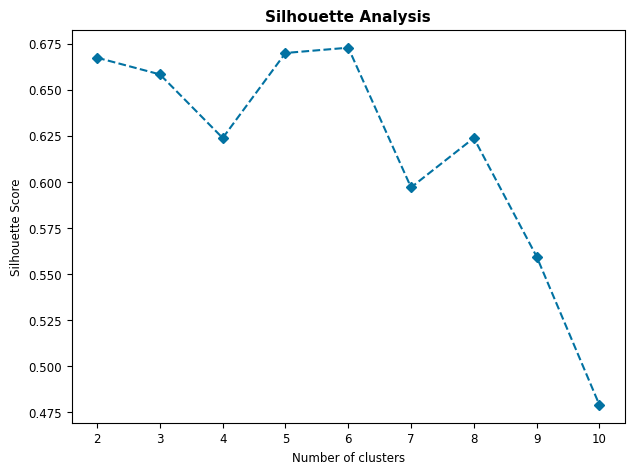

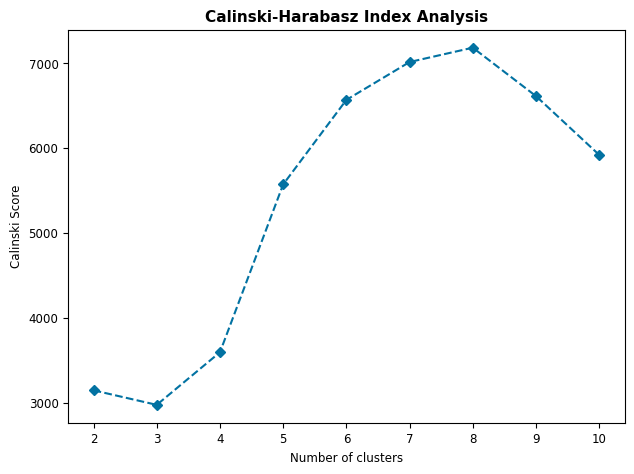

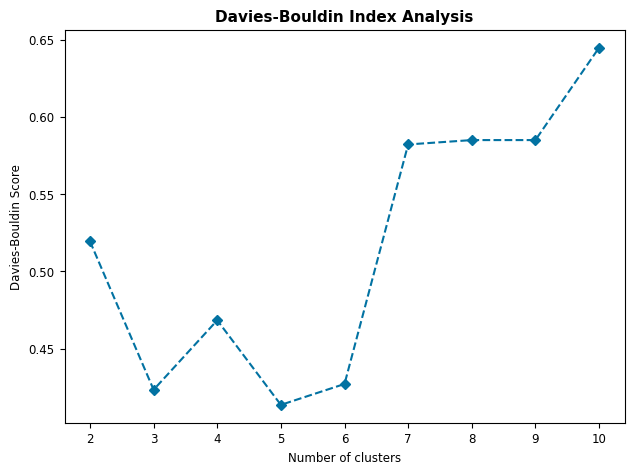

In [41]:
report_scores(data, np.arange(2, 11))

<h2>Moon dataset</h2>

In [45]:
data = pd.read_csv('moon.csv').to_numpy()
X = data[:, :-1]
y = data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

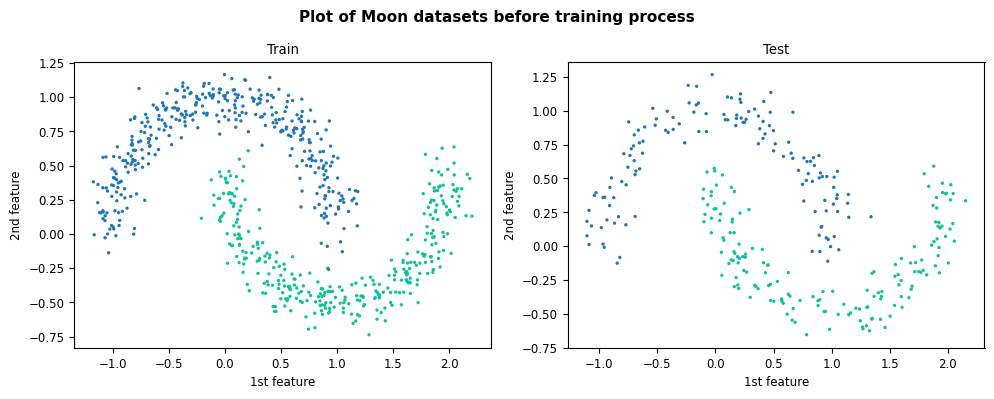

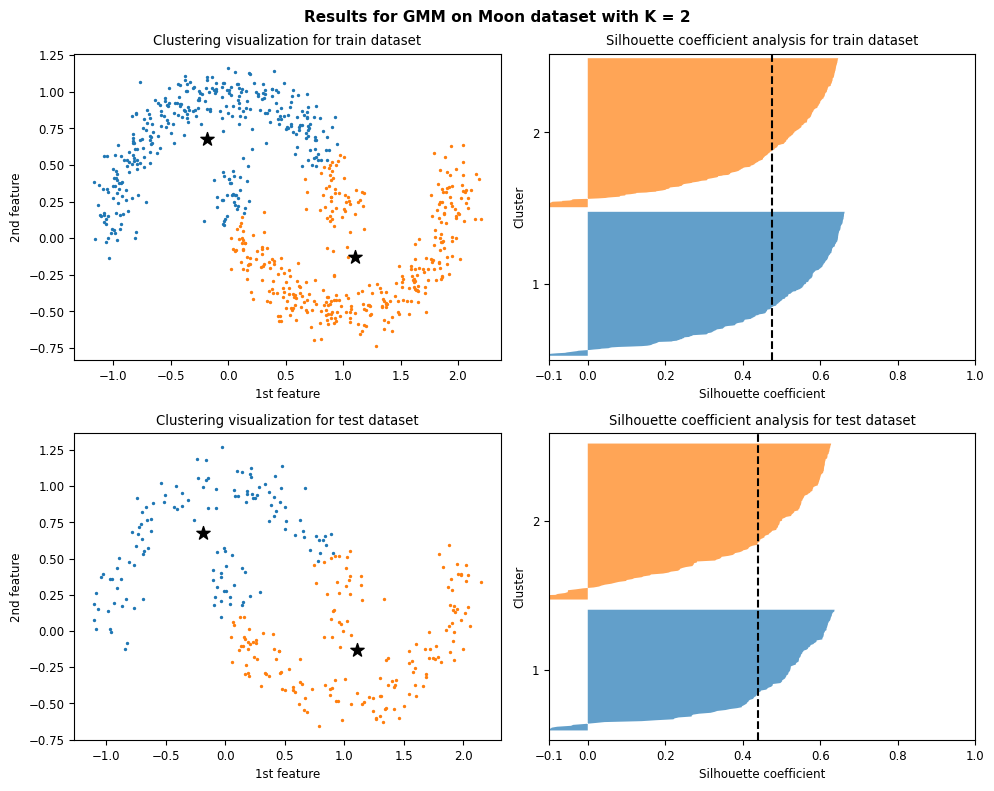

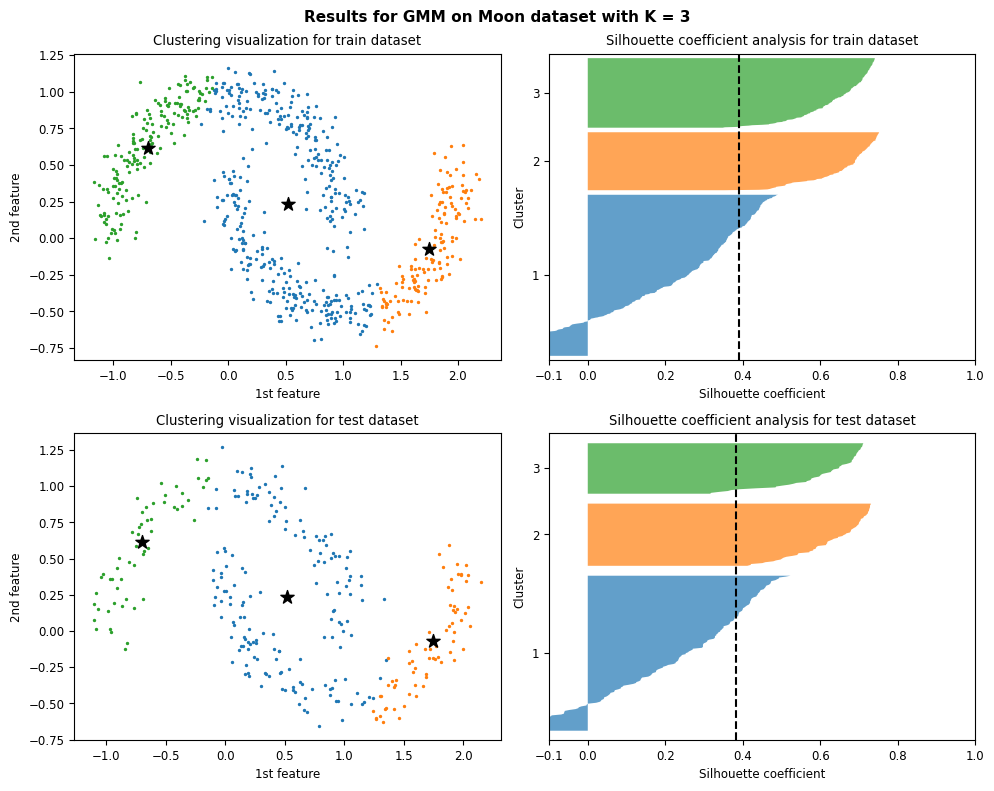

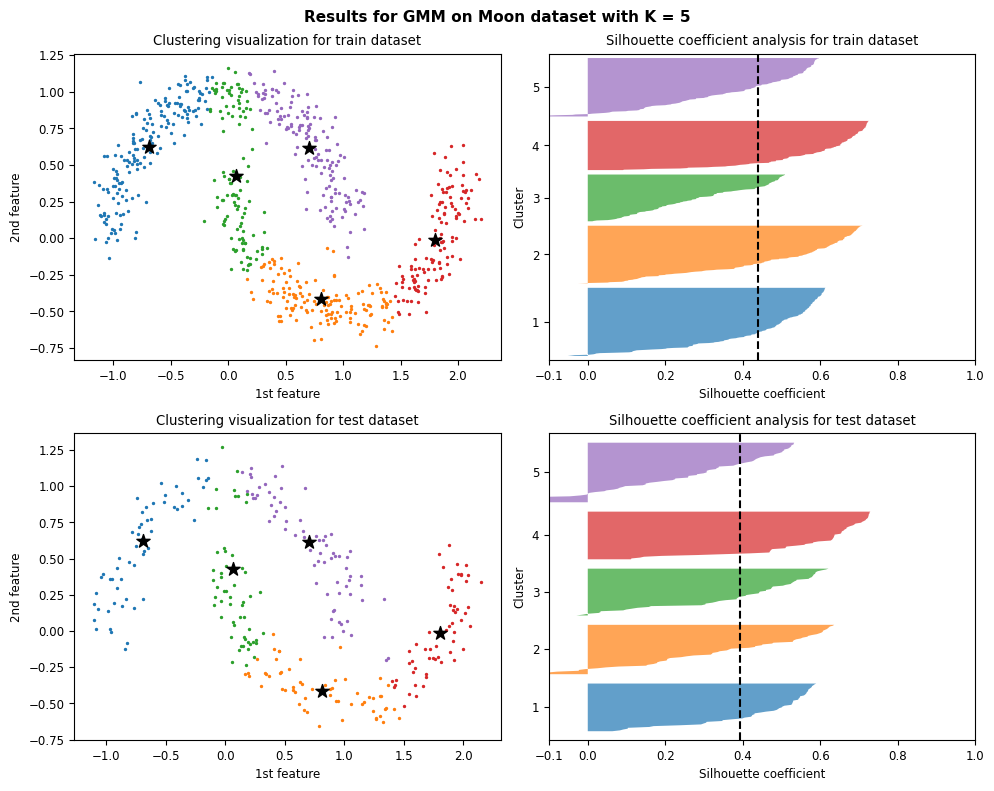

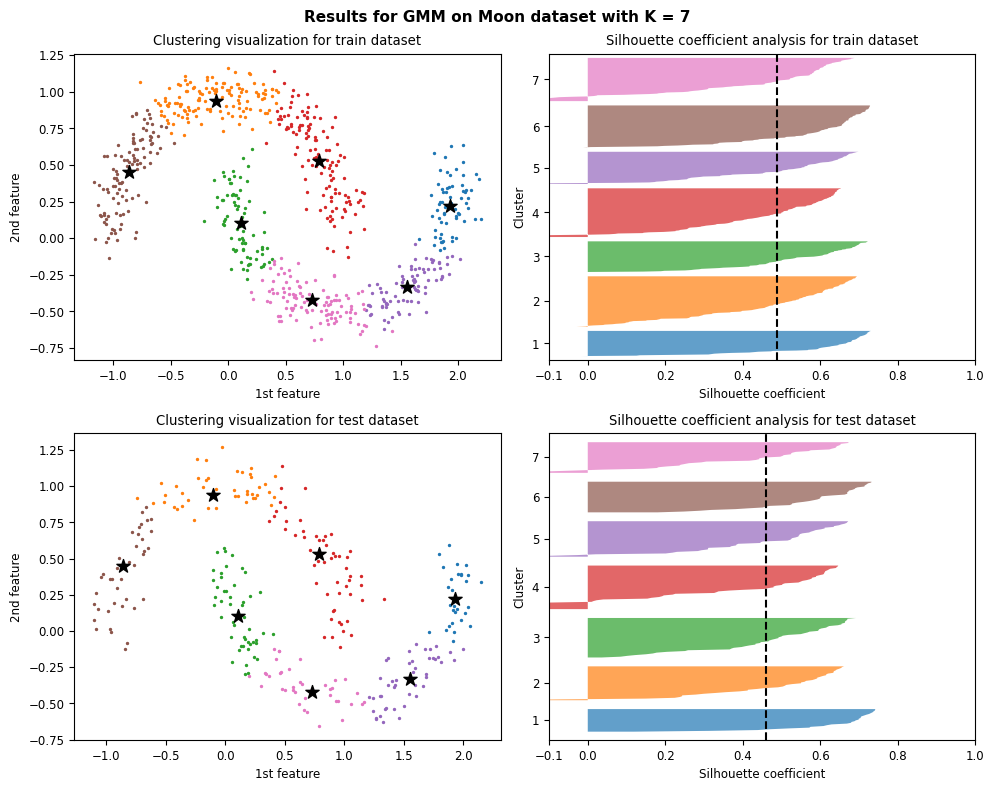

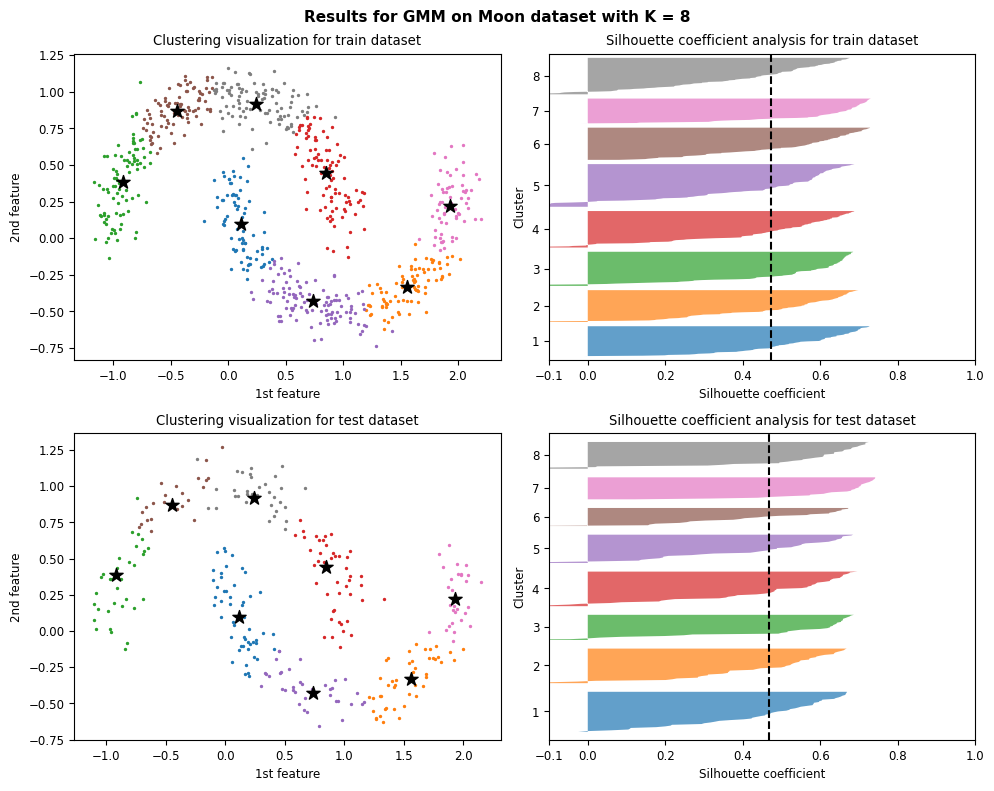

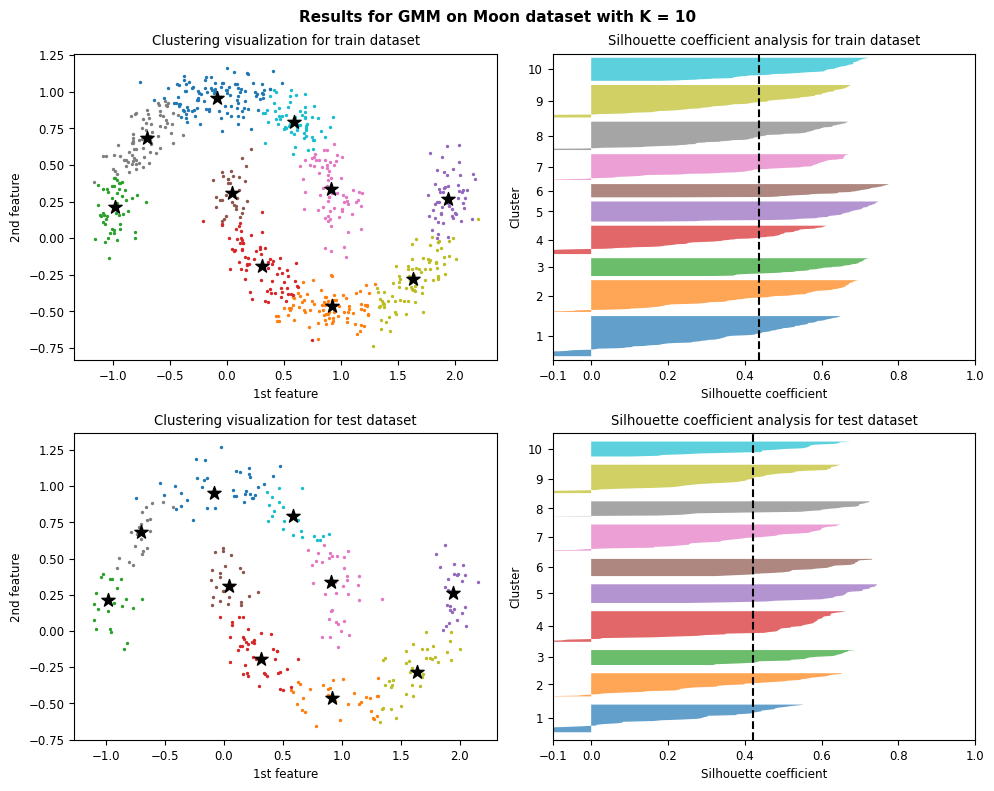

In [46]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
plot_data(X_train, y_train, ax=axs[0], title="Train")
plot_data(X_test, y_test, ax=axs[1], title="Test")
fig.suptitle(f"Plot of Moon datasets before training process", fontsize=11, fontweight="bold")
plt.tight_layout()

for k in k_s:
    model = GMM(n_clusters=k)
    model.fit(X_train)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    y_pred = model.predict(X_train)
    model.plot_predictions(X_train, y_pred, ax=axs[0, 0], title=f"Clustering visualization for train dataset")
    model.plot_silhouette(X_train, y_pred, ax=axs[0, 1], title="Silhouette coefficient analysis for train dataset")
    y_pred = model.predict(X_test)
    model.plot_predictions(X_test, y_pred, ax=axs[1, 0], title=f"Clustering visualization for test dataset")
    model.plot_silhouette(X_test, y_pred, ax=axs[1, 1], title="Silhouette coefficient analysis for test dataset")
    fig.suptitle(f"Results for GMM on Moon dataset with K = {k}", fontsize=11, fontweight="bold")
    plt.tight_layout()

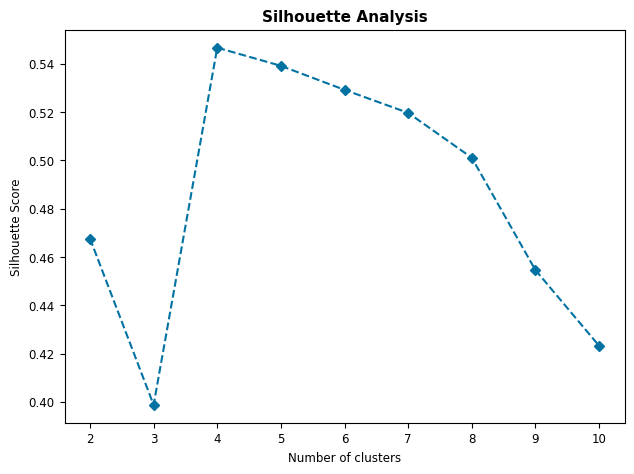

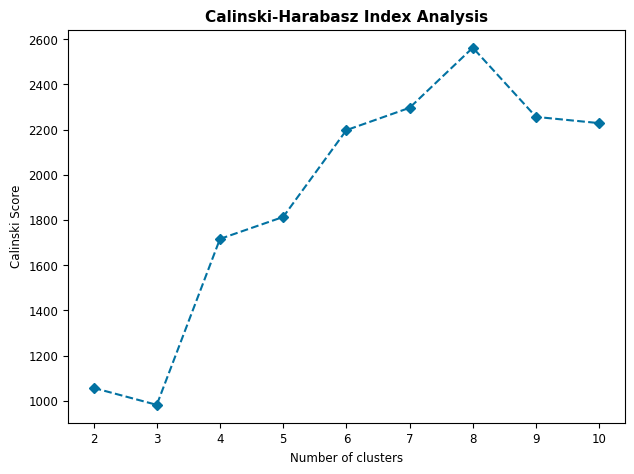

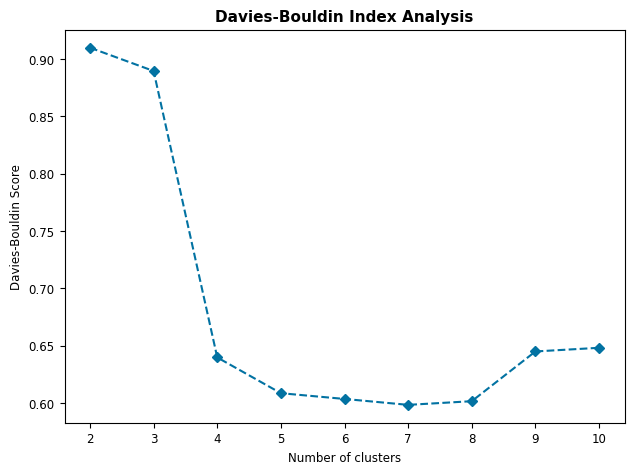

In [48]:
report_scores(data, np.arange(2, 11))

<h2>Circle dataset</h2>

In [52]:
data = pd.read_csv('circle.csv').to_numpy()
X = data[:, :-1]
y = data[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

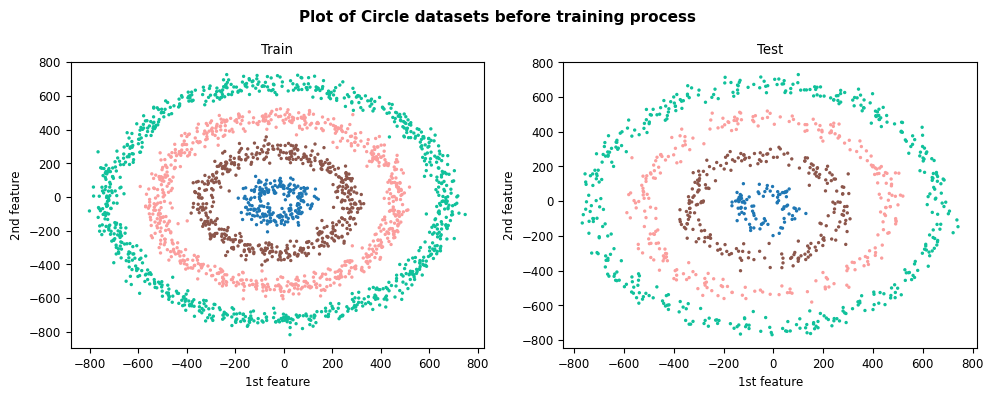

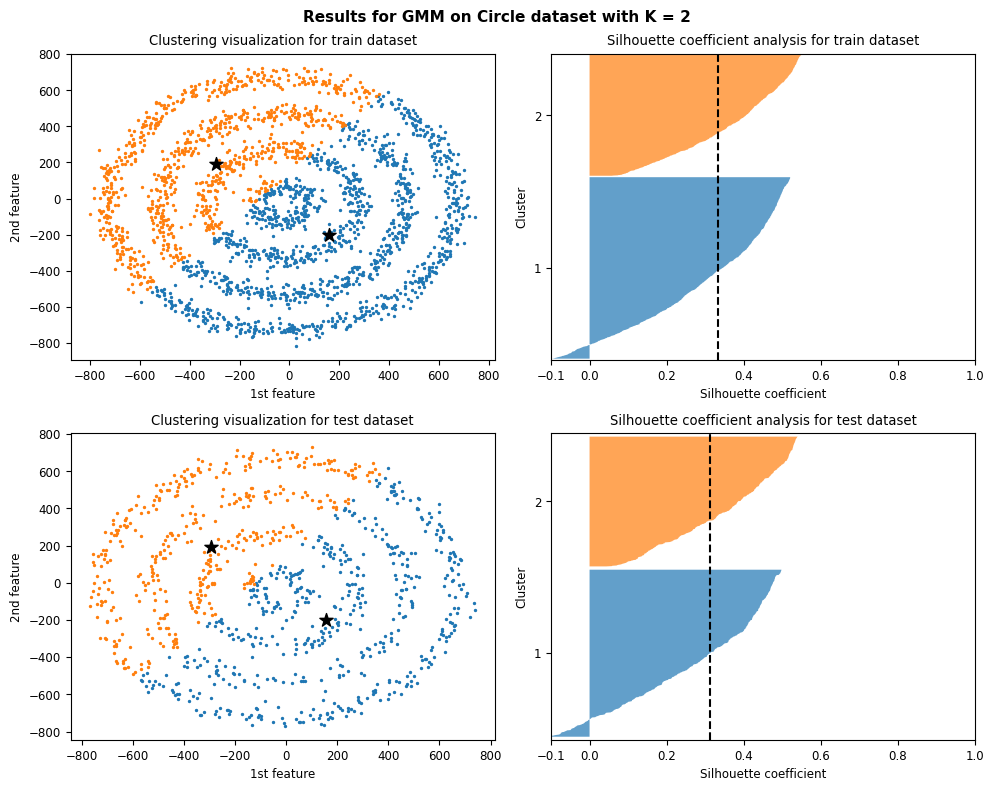

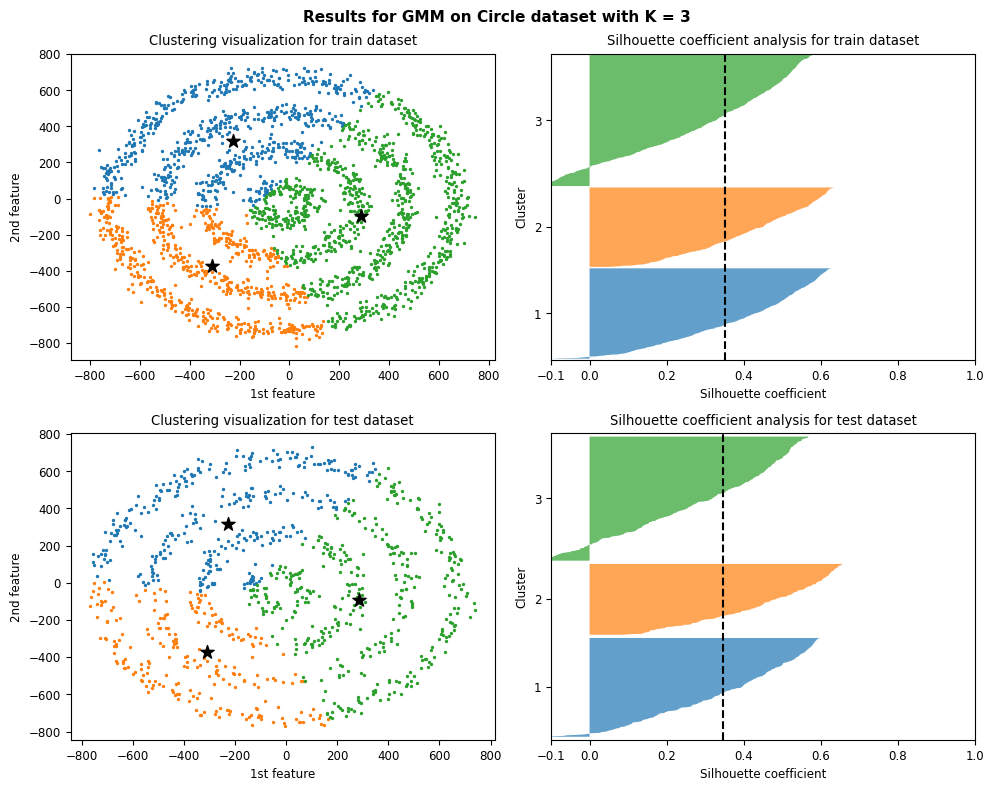

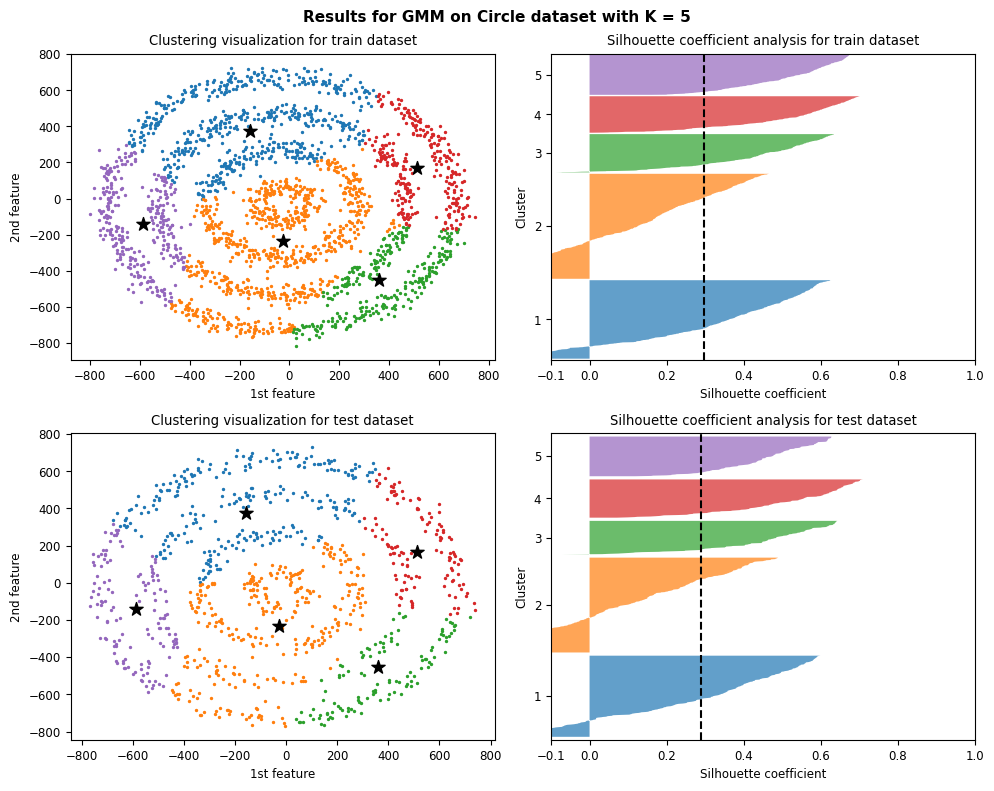

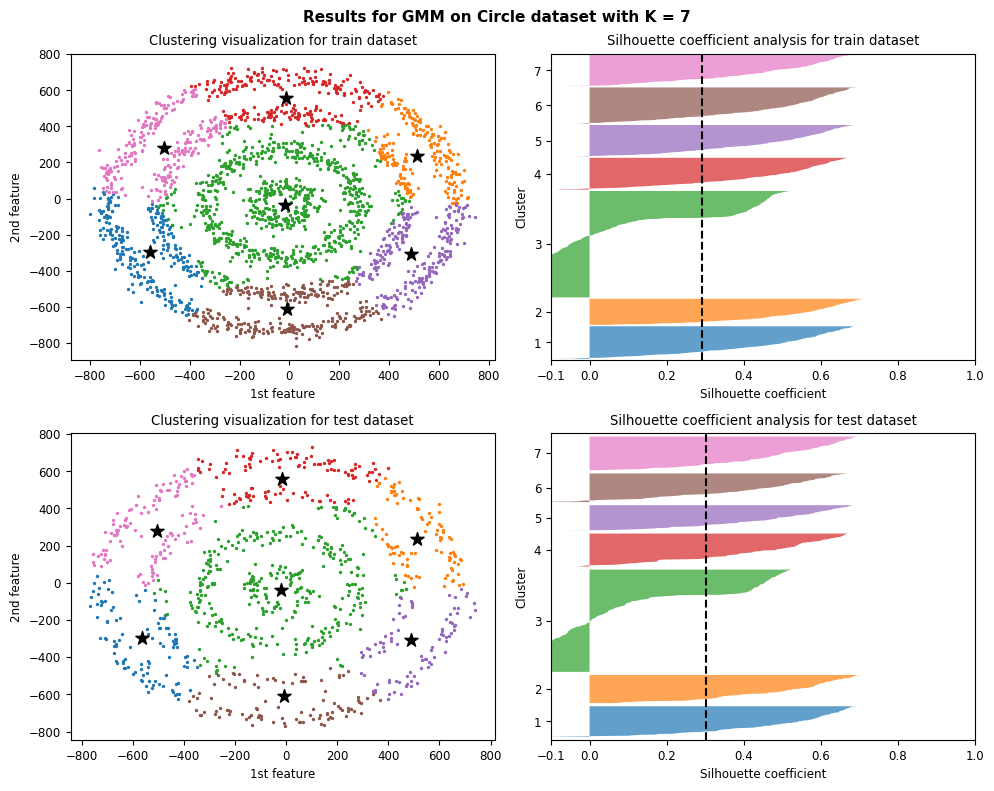

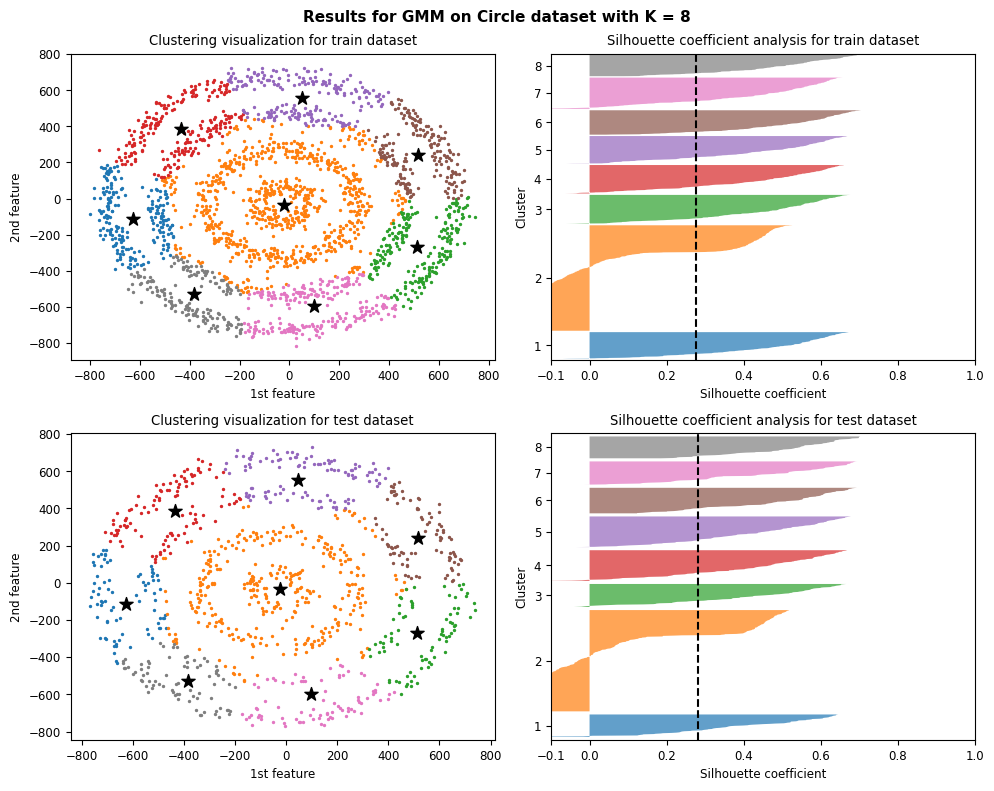

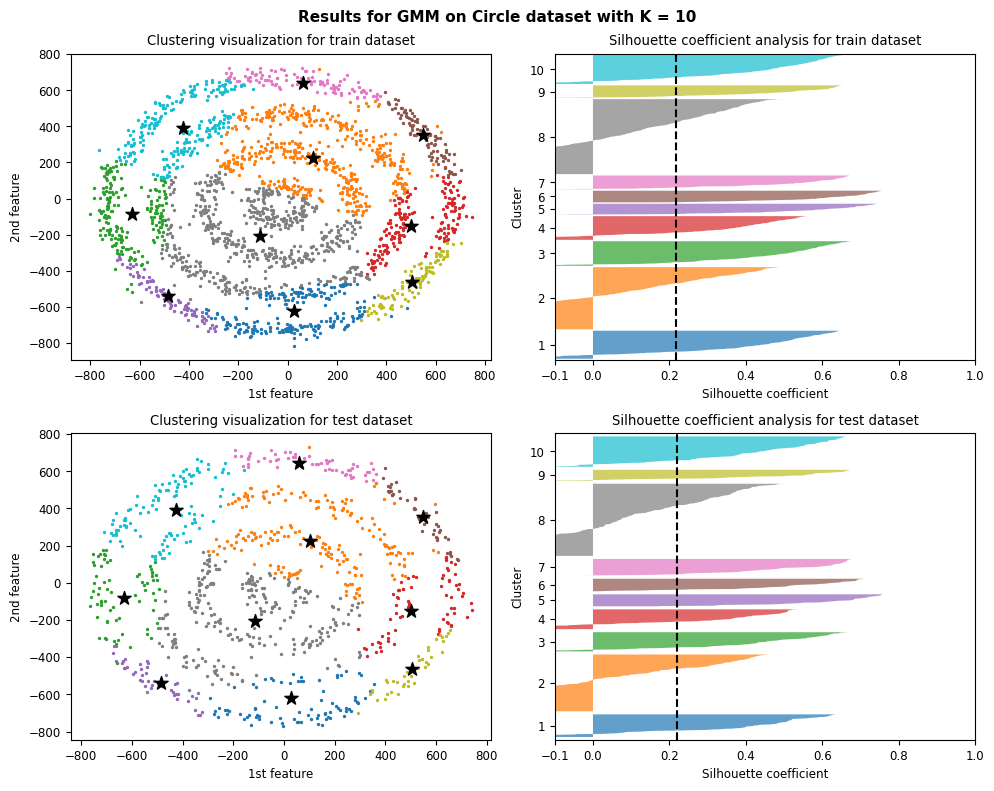

In [53]:
fig, axs = plt.subplots(1,2, figsize=(10, 4))
plot_data(X_train, y_train, ax=axs[0], title="Train")
plot_data(X_test, y_test, ax=axs[1], title="Test")
fig.suptitle(f"Plot of Circle datasets before training process", fontsize=11, fontweight="bold")
plt.tight_layout()

for k in k_s:
    model = GMM(n_clusters=k)
    model.fit(X_train)
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    y_pred = model.predict(X_train)
    model.plot_predictions(X_train, y_pred, ax=axs[0, 0], title=f"Clustering visualization for train dataset")
    model.plot_silhouette(X_train, y_pred, ax=axs[0, 1], title="Silhouette coefficient analysis for train dataset")
    y_pred = model.predict(X_test)
    model.plot_predictions(X_test, y_pred, ax=axs[1, 0], title=f"Clustering visualization for test dataset")
    model.plot_silhouette(X_test, y_pred, ax=axs[1, 1], title="Silhouette coefficient analysis for test dataset")
    fig.suptitle(f"Results for GMM on Circle dataset with K = {k}", fontsize=11, fontweight="bold")
    plt.tight_layout()

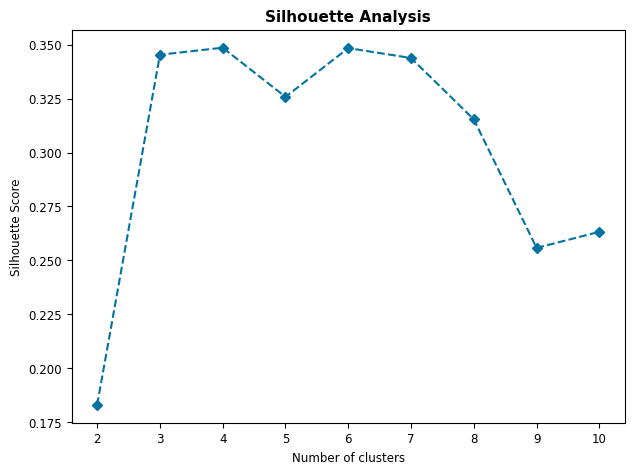

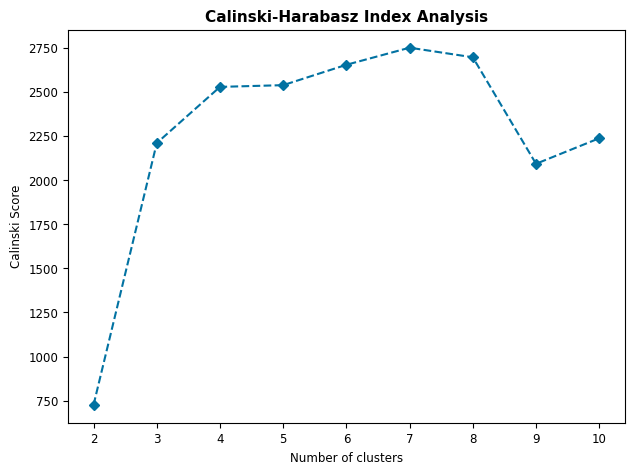

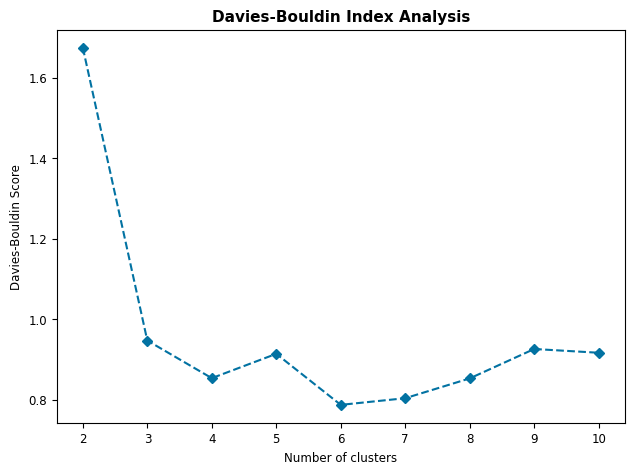

In [54]:
report_scores(data, np.arange(2, 11))